In [20]:
import scipy.special
import matplotlib.pyplot as plt
%matplotlib inline

# Questions:

1.  

In [25]:
from __future__ import print_function
import argparse
import h5py as h5
import os.path as path
import numpy as np
import math
import Corrfunc
from Corrfunc._countpairs import countpairs

parser = argparse.ArgumentParser()

parser.add_argument('boxsize') #L
parser.add_argument('bin_file')
parser.add_argument('mock_file1')
parser.add_argument('mock_file2')
parser.add_argument('output_file')
parser.add_argument('--siglnMc') #scatter between intrinsic 
parser.add_argument('--nc') #cluster number density
parser.add_argument('--zphot') #photo-z
parser.add_argument('--Qsel') #assembly bias term 
parser.add_argument('--delg') #R_delta
parser.add_argument('--downsample_flag')

_StoreAction(option_strings=['--downsample_flag'], dest='downsample_flag', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

# Halo occupation model

The occupation number of the halos is parametrized by 

$<N_{cen}(M)> = \frac{1}{2} [1+\text{erf} (\frac{\log M - \log M_{min}} {\sigma_{\log M}})] $

whose shape can be plotted as the following

<ipython-input-22-761f299786ce>:2: RuntimeWarning: divide by zero encountered in log
  return 0.5*(1+scipy.special.erf(np.log(M)/0.6))


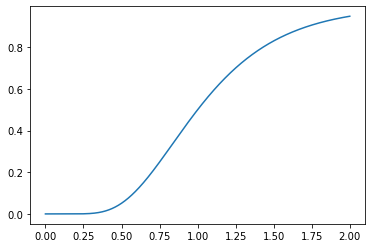

In [22]:
def N_cen(M):
    return 0.5*(1+scipy.special.erf(np.log(M)/0.6))

x = np.linspace(0,2,1000)
y = N_cen(x)

plt.plot(x,y)

The mean satellite number is defined by 
$<N_{sat}(M)> = <N_{cen}(M)> (\frac{M-M_0}{M_1})^{\alpha}$

which has a power-law shape. 

# Calculate Observed Halo Mass 

From Salcedo et al. 2020. 
The cluster-mass observable relation is a linear relation with a constant lognormal scatter:

$\ln M_{obs} = \ln M_c + \sigma_{\ln M_c} X $

The minimal mass for a halo to host a central is $\log M_{min} = \log M_{min,0} + Q_{env}(R_{\delta} - 0.5)$, in which $Q_{env}$ is the environmental dependence of galaxy occupation parameter. $R_\delta$ is the rank of halo environmental density measured with top-hat spheres of radius $8 h^{-1} \text{Mpc}$

In [23]:
args = parser.parse_args()

boxsize = float(args.boxsize)
nthreads = 4
binfile = path.abspath(str(args.bin_file))

if args.siglnMc:
  Ncluster = math.floor( (boxsize**3.0) * float(args.nc) ) #number of cluster
  infile = h5.File(str(args.mock_file1), 'r')
  halos = infile['halos'] 
  halos = halos[halos['mass'] > 0] #halo mass that passes M_min
  Nh = int(len(halos)) #number of halos
  infile.close()
  np.random.seed(0)
  randnorms = np.random.normal(0.0, 1.0, Nh)
  percentiles = h5.File(str(args.delg), 'r')['halos']['percentile'] #Delta_gamma
  halos['mass'] = np.exp( np.log(halos['mass']) + float(args.siglnMc) * randnorms + float(args.Qsel) * (percentiles - 0.5))
  halos.sort(order='mass')
  mock1 = halos[-Ncluster:] #only choose most massive clusters
  dummy2 = h5.File(str(args.mock_file2), 'r')
  mock2 = dummy2['particles']
else:
  dummy1 = h5.File(str(args.mock_file1), 'r')
  mock1 = dummy1['particles']
  dummy2 = h5.File(str(args.mock_file2), 'r')
  mock2 = dummy2['particles']
  if args.downsample_flag: #1/10 downsampling
    mock1 = mock1[::10]
    mock2 = mock2[::10]

usage: ipykernel_launcher.py [-h] [--siglnMc SIGLNMC] [--nc NC] [--zphot ZPHOT] [--Qsel QSEL] [--delg DELG]
                             [--downsample_flag DOWNSAMPLE_FLAG]
                             boxsize bin_file mock_file1 mock_file2 output_file
ipykernel_launcher.py: error: the following arguments are required: bin_file, mock_file1, mock_file2, output_file


SystemExit: 2

/global/homes/z/zchusre/.conda/envs/desdesi/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3259: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
N1 = len(mock1)
N2 = len(mock2)

x1 = mock1['x'].astype(np.float32)
y1 = mock1['y'].astype(np.float32)

x2 = mock2['x'].astype(np.float32)
y2 = mock2['y'].astype(np.float32)

if args.zphot:
  z1 = mock1['zphot'].astype(np.float32)
  z2 = mock2['zphot'].astype(np.float32)
else:
  z1 = mock1['z'].astype(np.float32)
  z2 = mock2['z'].astype(np.float32)

results_DD = countpairs(0, nthreads, binfile, X1=x1, Y1=y1, Z1=z1, X2=x2, Y2=y2, Z2=z2, verbose=True)[0]

#print(results_DD)

for i in range(0, len(results_DD)):
  RR = N1*N2*(4.0/3.0)*np.pi*(results_DD[i][1]**3.0 - results_DD[i][0]**3.0) / boxsize**3.0
  results_DD[i] = results_DD[i] + ((results_DD[i][3]/RR - 1.0),)

#print(results_DD)

outfile = open(str(args.output_file), 'w')

outfile.write("# rmin rmax npairs xi\n")

for bin in results_DD:
  outfile.write(str(bin[0])+" "+str(bin[1])+" "+str(bin[3])+" "+str(bin[5])+"\n")

outfile.close()

if args.siglnMc:
  False
else:
  dummy1.close()
dummy2.close()

NameError: name 'mock1' is not defined

In [1]:
pwd

'/global/project/projectdirs/des/zhou/spt_lensing'